In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, MultiHeadAttention, BatchNormalization, Dropout, Bidirectional

## For Visulation
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
govt_file_path = "/kaggle/input/stock-market-dataset/etfs/GOVT.csv"

# Load the latest version
govt_df = pd.read_csv(govt_file_path)

# You can also print information about the DataFrame
print(govt_df.info())

#Pring the first 5 records for quick inspection
print("First 5 records:", govt_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2039 non-null   object 
 1   Open       2039 non-null   float64
 2   High       2039 non-null   float64
 3   Low        2039 non-null   float64
 4   Close      2039 non-null   float64
 5   Adj Close  2039 non-null   float64
 6   Volume     2039 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 111.6+ KB
None
First 5 records:          Date   Open   High    Low  Close  Adj Close  Volume
0  2012-02-24  24.82  24.82  24.82  24.82  22.197924     100
1  2012-02-27  24.82  24.82  24.82  24.82  22.197924       0
2  2012-02-28  24.82  24.82  24.82  24.82  22.197924       0
3  2012-02-29  24.82  24.82  24.82  24.82  22.197924       0
4  2012-03-01  24.82  24.82  24.82  24.82  22.197924       0


### Purpose
This notebook is the Final Project Submission for Deep Learning Introduction UC-Boulder. It aims to predict govt bond prices given historical data and an LSTM based model.

The model is based on this paper --> https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/


In [3]:
### Lets standardize Date Column

govt_df['Date'] = pd.to_datetime(govt_df['Date']) 
print(govt_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2039 non-null   datetime64[ns]
 1   Open       2039 non-null   float64       
 2   High       2039 non-null   float64       
 3   Low        2039 non-null   float64       
 4   Close      2039 non-null   float64       
 5   Adj Close  2039 non-null   float64       
 6   Volume     2039 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 111.6 KB
None


### Lets first look at the stock trend to make sure the data looks complete

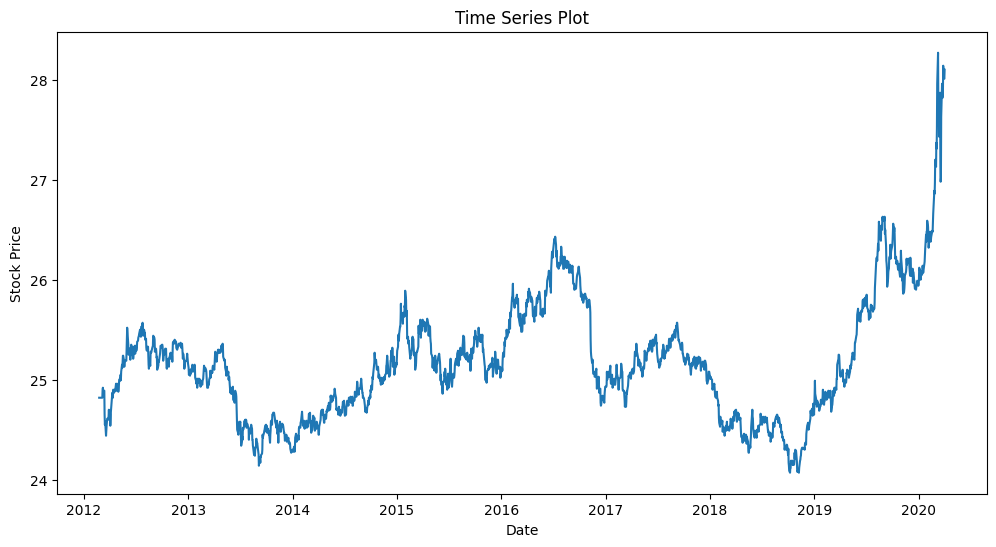

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(govt_df['Date'], govt_df['Close'])
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Initial Look
Lets look at the general stats on the Data as well as look for any missing values

In [5]:
print(govt_df.describe())

                                Date         Open         High          Low  \
count                           2039  2039.000000  2039.000000  2039.000000   
mean   2016-03-13 17:49:13.800882688    25.179107    25.216057    25.138715   
min              2012-02-24 00:00:00    23.820000    24.110001    23.820000   
25%              2014-03-06 12:00:00    24.750000    24.799999    24.709999   
50%              2016-03-15 00:00:00    25.120001    25.160000    25.090000   
75%              2018-03-22 12:00:00    25.440001    25.480000    25.389999   
max              2020-04-01 00:00:00    28.510000    28.540001    28.170000   
std                              NaN     0.604263     0.614115     0.596774   

             Close    Adj Close        Volume  
count  2039.000000  2039.000000  2.039000e+03  
mean     25.175449    23.599917  1.297894e+06  
min      24.070000    21.858068  0.000000e+00  
25%      24.740000    22.711895  7.475000e+04  
50%      25.129999    23.522623  3.594000e+05  


In [6]:
print(govt_df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


As we can see above this is cleaned data as input, so we don't need to impute or account fo missing incomplete data

## Check for time blocks
lets see if there is some sort of anual or sesonal trends

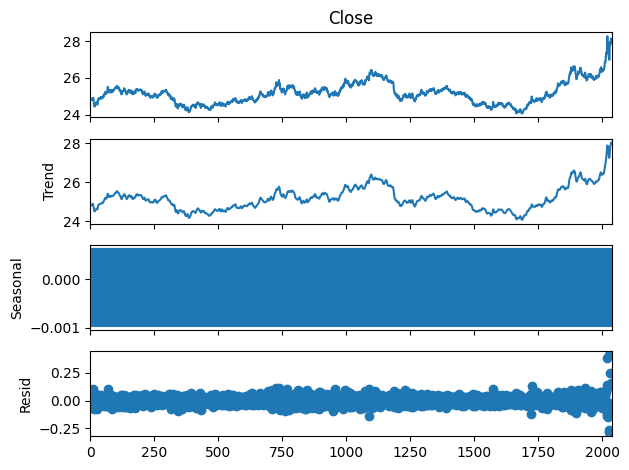

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(govt_df['Close'], model='additive', period=4)
decomposition.plot()
plt.show()

## Corelation

Lets look at the corelation Data

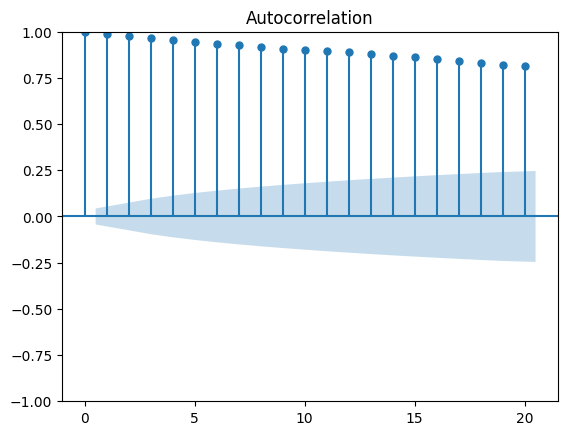

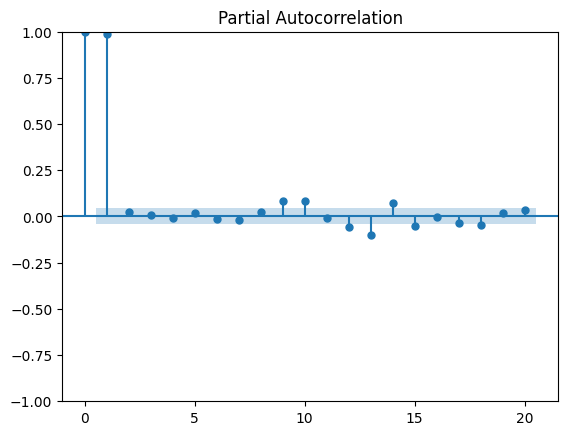

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(govt_df['Close'], lags=20)
plt.show()
plot_pacf(govt_df['Close'], lags=20)
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(govt_df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.226601
p-value: 0.973715
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


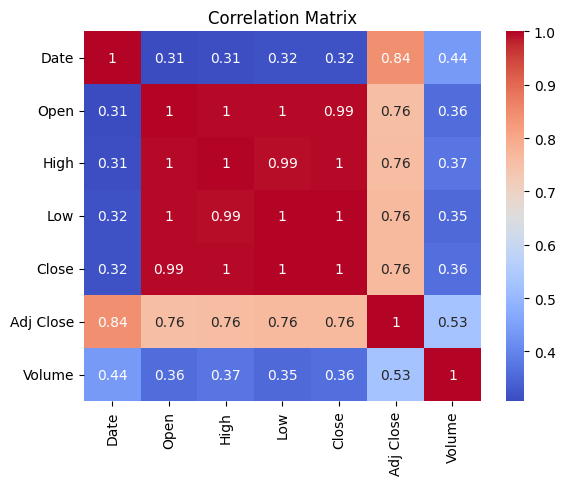

In [10]:
correlation_matrix = govt_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Lets trim the data 
Based on the correlation Matrix, Focus on the Adj Closing Prices only. This is what we really care about in our Model trend


In [11]:
govt_close = govt_df['Adj Close']
govt_close_values = govt_close.values
govt_close_values = govt_close_values.reshape(-1,1)

print (govt_close_values)

[[22.19792366]
 [22.19792366]
 [22.19792366]
 ...
 [27.97299957]
 [27.97299957]
 [28.10000038]]


### Scale the Close Price data to -1 to 1 to help with training

In [12]:
stockScaler = MinMaxScaler(feature_range=(0,1))
#Transform the Values
govt_df ['adj_values_scaled'] = stockScaler.fit_transform(govt_close_values)
print(govt_df ['adj_values_scaled'])

0       0.053314
1       0.053314
2       0.053314
3       0.053314
4       0.053314
          ...   
2034    0.938900
2035    0.979633
2036    0.959267
2037    0.959267
2038    0.979190
Name: adj_values_scaled, Length: 2039, dtype: float64


## Lets Plot the Data to ensure the trend is still the same

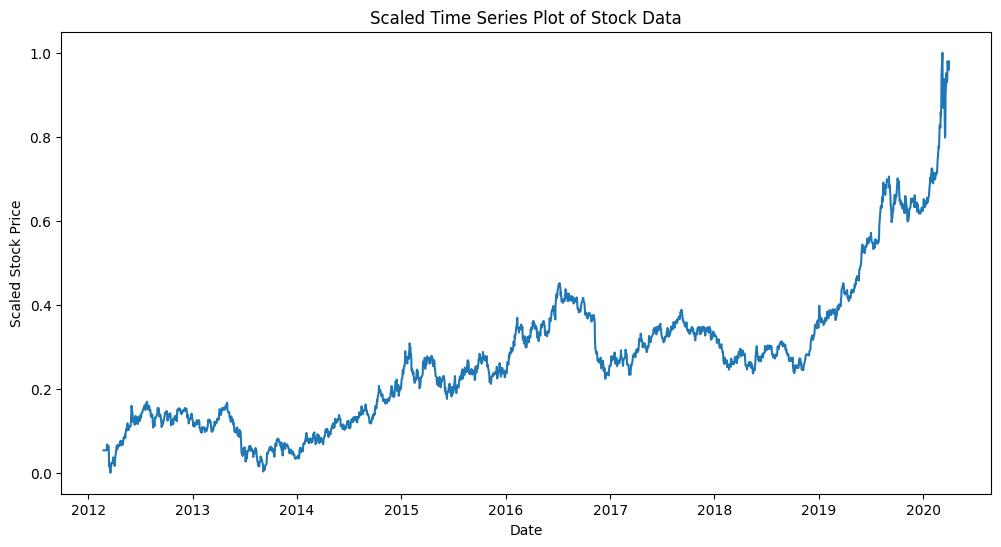

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(govt_df['Date'], govt_df ['adj_values_scaled'])
plt.title('Scaled Time Series Plot of Stock Data')
plt.xlabel('Date')
plt.ylabel('Scaled Stock Price')
plt.show()

Lets Start the training with this cleaned data

In [14]:
## Split the data for testing
ts_split = TimeSeriesSplit(n_splits=5)  # Create a 5-fold time series split
for train_index, test_index in ts_split.split(govt_df['adj_values_scaled']):
    train_data = govt_df['adj_values_scaled'].iloc[train_index].values
    test_data = govt_df['adj_values_scaled'].iloc[test_index].values

In [15]:
print(train_data)

[0.05331406 0.05331406 0.05331406 ... 0.28216252 0.28216252 0.28063594]


Lets Smooth the Training data to remove sudden spikes

In [16]:
# We will use exponential moving average smoothing
#EMA = 0.00
#gamma = 0.01
#for ti in range(len(train_data)):
#  EMA = gamma*train_data[ti] + (1-gamma)*EMA
#  train_data[ti] = EMA

Lets look at an averaging filter to do a one time step look ahead

In [17]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    date = govt_df.loc[pred_idx,'Date']
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for standard averaging: 0.00079


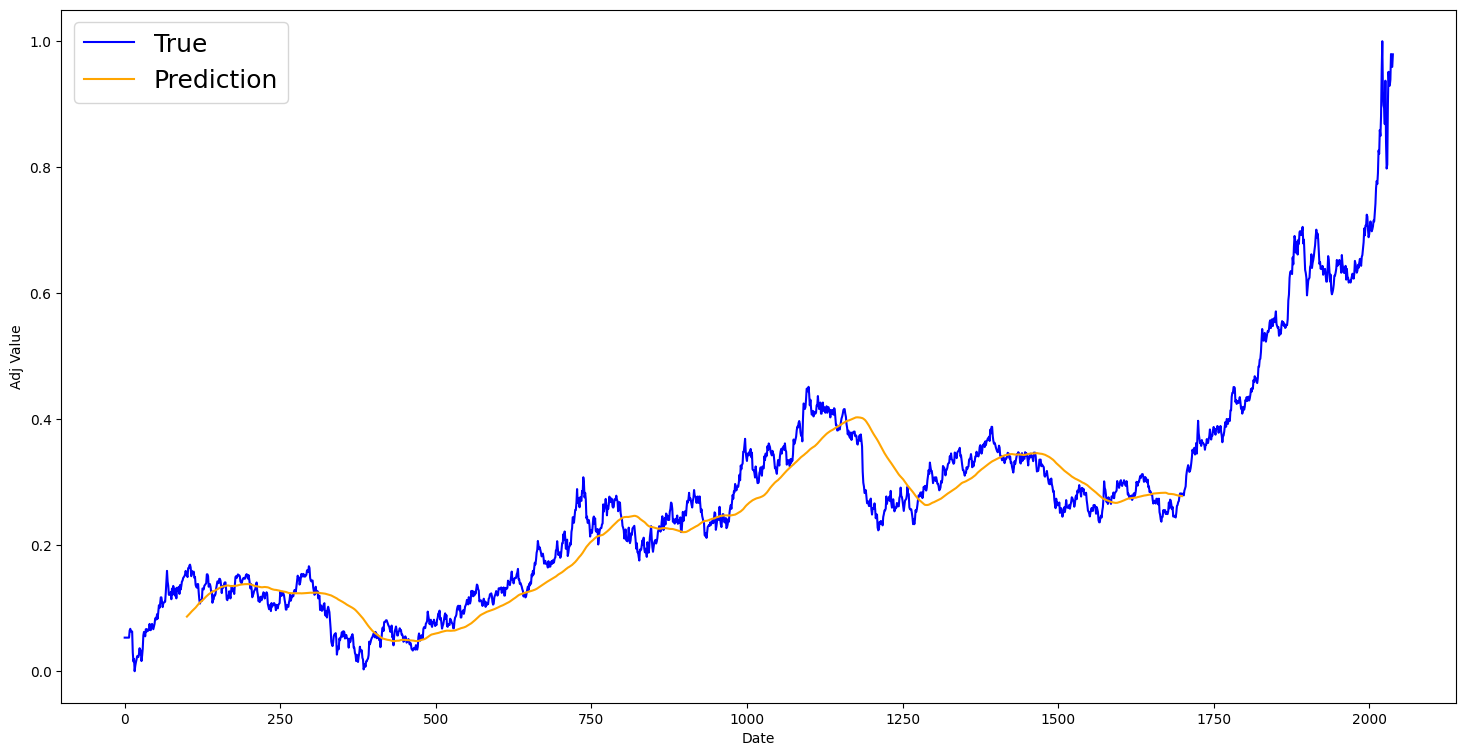

In [18]:
plt.figure(figsize = (18,9))
plt.plot(range(govt_df.shape[0]),govt_df['adj_values_scaled'],color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Adj Value')
plt.legend(fontsize=18)
plt.show()

We can see that the Averaging Method does not follow the price that well. So Lets try an Exponential Moving Average. 

In [19]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00004


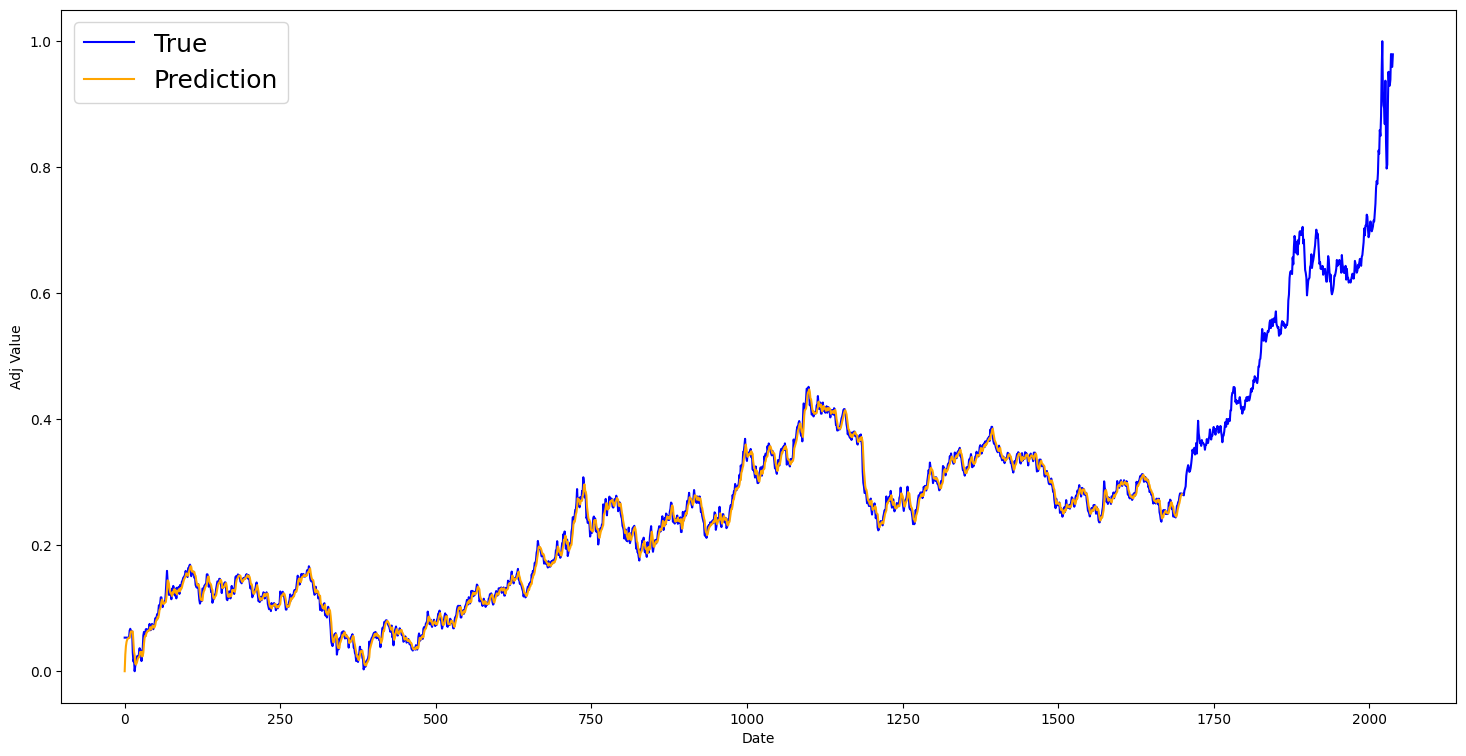

In [20]:
plt.figure(figsize = (18,9))
plt.plot(range(govt_df.shape[0]),govt_df['adj_values_scaled'],color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Adj Value')
plt.legend(fontsize=18)
plt.show()


This much better tracking but we can improve the prediction further. So lets try LSTMS in Tensorflow

In [21]:
# Prepare the data
n_steps = 50  # Number of time steps to consider for prediction
X, y = [], []
for i in range(len(govt_df) - n_steps):
    X.append(govt_df['adj_values_scaled'][i:i+n_steps])
    y.append(govt_df['adj_values_scaled'][i+n_steps])
X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [22]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(n_steps, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0106
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.1484e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.2592e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.2470e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.1729e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.1394e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9962e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.9645e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.7588e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.6216e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.5792e-04
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.5886e-04
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5771e-04
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3981e-04
Epoch

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


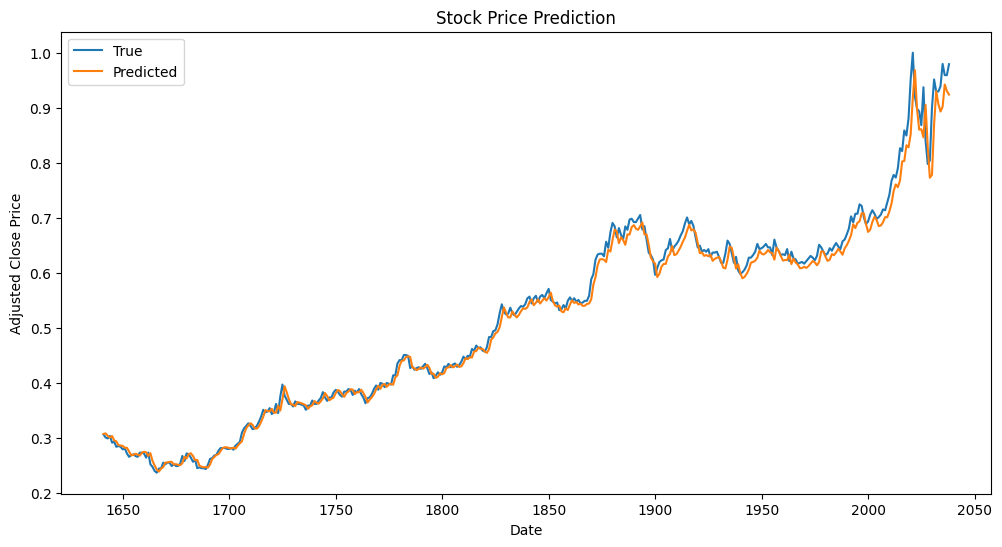

In [24]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(govt_df.index[train_size+n_steps:], y_test, label='True')
plt.plot(govt_df.index[train_size+n_steps:], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

As we can see the prediction is prety great with an LSTM. But our model was very basic, lets add more details and see if we can track the true value even closer.history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint], verbose=1)

In [25]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(n_steps, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='mean_squared_error')

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint, reduce_lr], verbose=1)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 1.5229
Epoch 1: val_loss improved from inf to 0.43354, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - loss: 1.5108 - val_loss: 0.4335 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.4784
Epoch 2: val_loss did not improve from 0.43354
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.4780 - val_loss: 0.7825 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.3656
Epoch 3: val_loss did not improve from 0.43354
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.3653 - val_loss: 0.7409 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.3203
Epoch 4: val_loss did not improve from 0.43354
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.3194 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2365
Epoch 5: val_loss did not improve from 0.

In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 50, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 908,229 (3.46 MB)

 Trainable params: 302,465 (1.15 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 604,932 (2.31 MB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


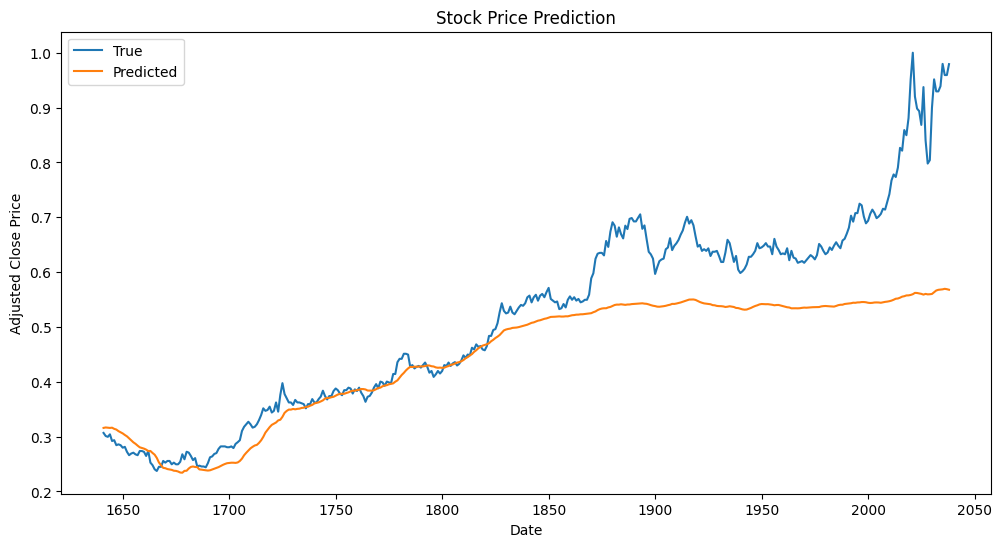

In [28]:
model.load_weights('best_model.keras')

# Make predictions on the test set
y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(govt_df.index[train_size+n_steps:], y_test, label='True')
plt.plot(govt_df.index[train_size+n_steps:], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

### Conclusions
Playing around with a more advanced model and trying dynamic learning rates and stoping early based on plateau, we can see that the advancded models in this case do not perform as well as the simpler model. Even the LSTM based model in this cased was only marginally (0.2%) better than the moveing average model. This is due to the nature of this prediction where we are using history to project forward, where as if we started adding other more dynamic dimensions to this model, like competitor trends in the industry and their stock price history, compadies market data and any other raw forms to increase input dimentionality we can refind the predictions more accuratly with more advanced models for this use case.